In [20]:
"""
Medical Data Science fur Assistive Gesundheitstechnologien
Scenario 2

Authors
-------
  Karol Kęciński
  Vegard Haugland
"""

'\nMedical Data Science fur Assistive Gesundheitstechnologien\nScenario 2\n\nAuthors\n-------\n  Karol Kęciński\n  Vegard Haugland\n'

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [2]:
from zipfile import ZipFile
with ZipFile("/content/data.zip", 'r') as file:
  file.extractall()
  print('Done')

Done


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal as sg
import os
import math

DATAFOLDER = '/content/data'
FRAME = 20

In [4]:
def load_data(path):
  acc_data  = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter = ',')
  gyro_data = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter = ',')
  return acc_data.to_numpy(), gyro_data.to_numpy()

def sampling_frequency(data):
  last_recorded_time = data[-1][0]
  return round((len(data) - 100) / last_recorded_time / 10.0) * 10

def lowpass_filter(data, frequency):
  sos = sg.butter(N=2, Wn=1, btype='lowpass', analog=False, output='sos', fs=frequency)
  return sg.sosfiltfilt(sos, data, axis=0)

def peaks(data, frequency):
  norms = np.linalg.norm(data, axis = 1)
  min = np.min(norms)
  max = np.max(norms)
  normalised = (norms - min) / (max - min)
  peaks = sg.find_peaks(normalised, height = normalised.mean(), prominence = 0.1, width = 1, wlen = frequency)
  
  return normalised, len(peaks[0]), peaks[0]

def calculate_gravity_vector(data, frequency, idle_time = 10):
  Gx = np.mean(data[:idle_time * frequency, 0])
  Gy = np.mean(data[:idle_time * frequency, 1])
  Gz = np.mean(data[:idle_time * frequency, 2])

  return np.array([Gx, Gy, Gz])

def calculate_gravity_matrix(data, gravity_vector, mu):
  Gb = np.zeros_like(data)
  Gb[0] = gravity_vector
  for t in range(1, len(data)):
    Gb[t] = mu * Gb[t-1] + (1 - mu) * data[t]

  return Gb

def calculate_rotation_matrix(gravity_vector):
  v = np.array([0, 1, 0])
  Uz = gravity_vector
  Ux = np.cross(v, Uz)
  Uy = np.cross(Uz, Ux)

  return np.stack([Ux / np.linalg.norm(Ux), Uy / np.linalg.norm(Uy), Uz / np.linalg.norm(Uz)], axis = 1)

In [15]:
acc, gyro = load_data(path = os.path.join(DATAFOLDER, 'Track 3'))
frequency = sampling_frequency(acc)
timestamps = [_[0] for _ in acc]

<function matplotlib.pyplot.show>

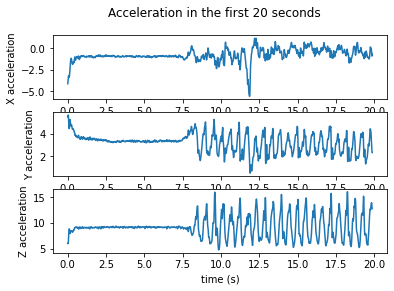

In [16]:
"""
  Displaying accelerometer data
"""

T = timestamps[:FRAME * frequency]
X = [_[1] for _ in acc[:FRAME * frequency]]
Y = [_[2] for _ in acc[:FRAME * frequency]]
Z = [_[3] for _ in acc[:FRAME * frequency]]


fig, axs = plt.subplots(3)
fig.suptitle('Acceleration in the first 20 seconds')

axs[0].plot(T, X)
axs[0].set(ylabel = 'X acceleration')
axs[1].plot(T, Y)
axs[1].set(ylabel = 'Y acceleration')
axs[2].plot(T, Z)
axs[2].set(ylabel = 'Z acceleration')

for ax in axs:
  ax.set(xlabel = 'time (s)')

plt.show

<function matplotlib.pyplot.show>

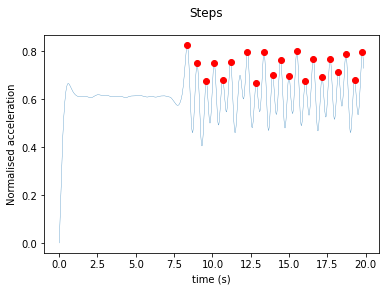

In [17]:
"""
  Displaying data
"""
acc = lowpass_filter(acc[:,1:], frequency)
normalised, steps_count, steps = peaks(acc[:,1:], frequency)

T = np.array(T)
steps_indices = steps[steps < len(T)]

fig, ax = plt.subplots()
fig.suptitle('Steps')

ax.plot(T, normalised[:FRAME * frequency], linewidth = 0.3, zorder = -1)
ax.scatter(T[steps_indices], normalised[steps_indices], c='r', marker='o')
ax.set(xlabel='time (s)', ylabel='Normalised acceleration')

plt.show

In [18]:
gyro_data = gyro[:,1:]

gravity_vector = calculate_gravity_vector(data = acc, frequency = frequency, idle_time = 10)
gravity_matrix = calculate_gravity_matrix(data = acc, gravity_vector = gravity_vector, mu = 0.7)

margin = 10

THz = np.zeros(len(timestamps) - margin)
TH = np.zeros(len(timestamps) - margin)

for k in range(1, len(timestamps) - margin):
  # Rotation matrix Rt
  Rt = np.transpose(calculate_rotation_matrix(gravity_matrix[k]))
  # Projected turn rate THz (Theta z)
  THz[k] = np.matmul(Rt, gyro_data[k])[2]
  # Time difference Delta t
  Dt = timestamps[k] - timestamps[k-1]

  # Turn angle Theta
  TH[k-1] = THz[k] * Dt 

  if k > 1:
    TH[k-1] += TH[k-2]

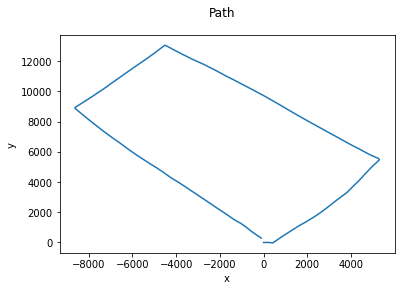

In [19]:
x = np.zeros(steps_count + 1)
y = np.zeros(steps_count + 1)

lambdaT = 70

for step in range(1, steps_count + 1):
  x[step] = x[step - 1] + lambdaT * np.cos(TH[steps[step - 1]])
  y[step] = y[step - 1] + lambdaT * np.sin(TH[steps[step - 1]])

fig, ax = plt.subplots()
fig.suptitle('Path')
ax.plot(x, y)
ax.set(xlabel = 'x', ylabel = 'y')
plt.show()